In [1]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

#Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler import
from sklearn.preprocessing import MinMaxScaler

# DBSCAN import
from sklearn.cluster import DBSCAN

#Import custom libraries
import wrangle as w 
import prepare as p

In [2]:
df = w.get_curriculum_data()

Returning saved csv files.


## Prepare:

- Deciding to drop nulls since they do not have a cohort associated to them and eliminates much of the earlier data during curriculum and cohort establishment making for a cleaner data frame. 
- Created a new column with description of program type for easier readability
- We have 52,893 nulls, and dropped them in our prepare.py
- Dropped 'deleted_at' column because no entries have a value, all are null, which means no web logs have been deleted
- Removed log entries for paths ending in image or json files

In [3]:

def prepare_data(df):

    df['timestamp'] = df['date'] + ' ' + df['time']
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Rename date and time columns to denote that they are log date and times
    df.rename(columns={"date": "log_date", "time": "log_time"})

    # Rename name column to cohort and id column to cohort_id
    df.rename(columns={"name": "cohort", "id": "cohort_id"})

    return df

def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'customer_id': 'num_rows'}).reset_index()
    return rows_missing

def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [4]:
df[df.name.isna() & df.program_id.isna()]

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,program_name
411,2018-01-26,16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
425,2018-01-26,17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
435,2018-01-26,18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
436,2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899897,2021-04-21,12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
899898,2021-04-21,12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
899899,2021-04-21,12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program
899900,2021-04-21,12:52:37,javascript-ii/promises,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown_program


<AxesSubplot:title={'center':'Which program types are the most popular?'}>

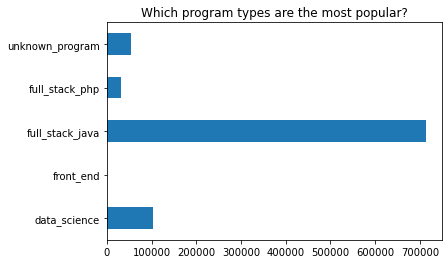

In [5]:
df.program_name.value_counts().sort_index().plot.barh(title="Which program types are the most popular?")



<AxesSubplot:title={'center':'Which cohorts are the most active online?'}>

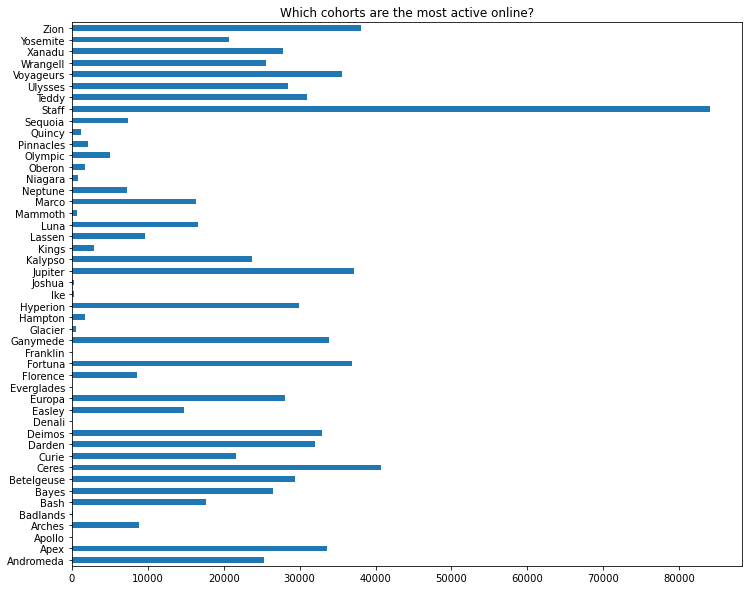

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
df.name.value_counts().sort_index().plot.barh(title="Which cohorts are the most active online?")


- After Code Up staff, Ceres was the most frequest accessor of the curriculum.


## Q1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?


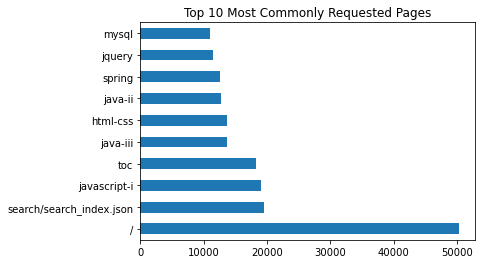

In [7]:
df.path.value_counts().head(10).plot.barh(
    title='Top 10 Most Commonly Requested Pages');

In [8]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [9]:
#Look at the top lessons accessed
path_df = value_counts_and_frequencies(df.path)
path_df.head(10)

,count,proba
/,50313,0.055889
search/search_index.json,19519,0.021682
javascript-i,18983,0.021087
toc,18297,0.020325
java-iii,13733,0.015255
html-css,13635,0.015146
java-ii,12685,0.014091
spring,12524,0.013912
jquery,11525,0.012802
mysql,11033,0.012256


## Answer:
<span class="mark">Out of the top ten most requested pages the javascript-i lesson looks to be the most commonly requested page</span>

## Q2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

- Will group by program type to compare cohorts and then look at the max lessons viewed and how they compared to other cohorts.
- Will also group paths by module splitting the lessons at the first '/' to categorize into modules instead of individual lessons.

In [ ]:
#Let's take a look at user lesson counts
lesson_counts_by_cohort = df.groupby(['name'])['date','name','path'].nunique()

In [12]:
#Let's take a look at user lesson counts by path
lesson_counts_by_path = df.groupby(['path'])['date','name'].nunique()

In [11]:
#Create an initial lesson category to group paths by
df['module_1'] = df.path.str.split('/').str[0]
df['module_2'] = df.path.str.split('/').str[1]


In [13]:
# Let's create a subset of data science students to compare lessons by cohort
ds_cohorts = df[(df['program_name'] == 'data_science')  & (df['name'] != 'staff')]

In [14]:
ds_lesson_counts_by_path = ds_cohorts.groupby(['name'])['module_1','path'].nunique()


<AxesSubplot:ylabel='name'>

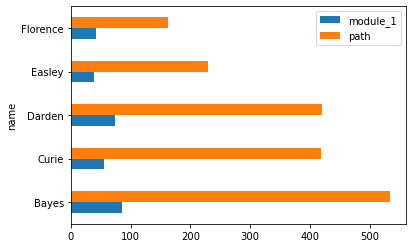

In [15]:
ds_lesson_counts_by_path.plot.barh()

Text(0.5, 1.0, 'Most Frequently Accessed Lessons for Bayes')

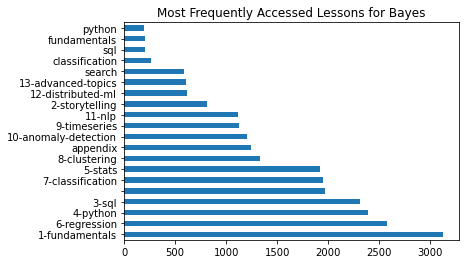

In [16]:
ds_bayes = ds_cohorts[ds_cohorts['name']== 'Bayes']
dsb = ds_bayes.module_1.value_counts()
dsb.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Bayes")

Text(0.5, 1.0, 'Most Frequently Accessed Lessons for Curie')

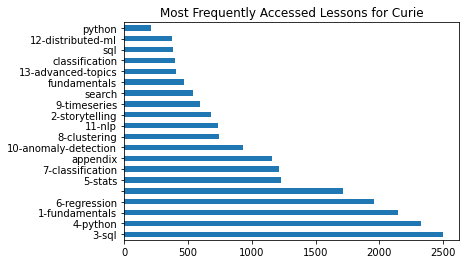

In [19]:
ds_curie = ds_cohorts[ds_cohorts['name']== 'Curie']
dsc = ds_curie.module_1.value_counts()
dsc.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Curie")

Text(0.5, 1.0, 'Most Frequently Accessed Lessons for Darden')

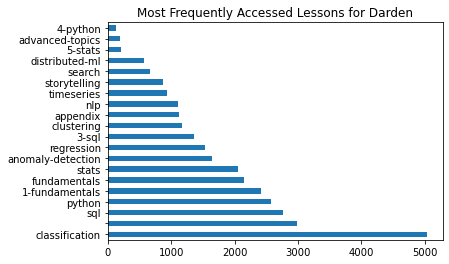

In [20]:
ds_darden = ds_cohorts[ds_cohorts['name']== 'Darden']
dsd = ds_darden.module_1.value_counts()
dsd.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Darden")

Text(0.5, 1.0, 'Most Frequently Accessed Lessons for Easley')

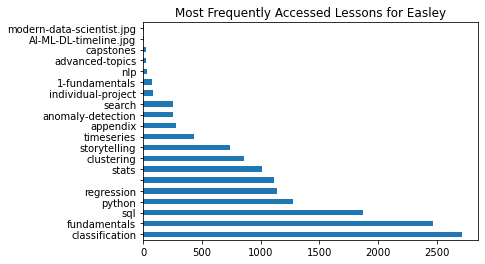

In [17]:
ds_easley = ds_cohorts[ds_cohorts['name']== 'Easley']
dse = ds_easley.module_1.value_counts()
dse.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Easley")

Text(0.5, 1.0, 'Most Frequently Accessed Lessons for Florence')

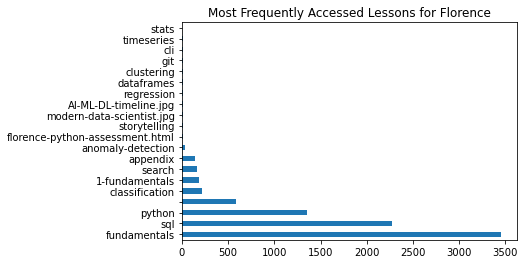

In [18]:
ds_florence = ds_cohorts[ds_cohorts['name']== 'Florence']
dsf = ds_florence.module_1.value_counts()
dsf.head(20).plot.barh()
plt.title ("Most Frequently Accessed Lessons for Florence")

## Answer: <span class="mark">- The Classification module in the curriculum was accessed significantly more by Darden compared to the other cohorts.</span>